In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F 
import pandas as pd
import torch
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
random_seed = 123
torch.manual_seed(random_seed)
np.random.seed(random_seed)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
df = pd.read_pickle("../../data/updated_molecules.pth")

In [3]:
BATCHSIZE = 128
N_TRAIN_EXAMPLES = BATCHSIZE * 30
N_VALID_EXAMPLES = BATCHSIZE * 10

In [4]:
scalar = MinMaxScaler()
data = df["fingerprint_polyBERT"]
target = df["Egc"]

#data = data.values.reshape(-1, 1)  # Reshape data

data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.2, random_state=123)

# Scaling target variable
target_train = scalar.fit_transform(target_train.values.reshape(-1, 1))
target_test = scalar.transform(target_test.values.reshape(-1, 1))

# Creating tensors from data

#Training Data
data_train_tensor = torch.tensor(data_train.reset_index(drop = True), dtype=torch.float32)
target_train_tensor = torch.tensor(target_train, dtype=torch.float32)

train_dataset = TensorDataset(data_train_tensor, target_train_tensor)
train_loader = DataLoader(train_dataset, batch_size= BATCHSIZE, shuffle= True)

#Testing Data

data_test_tensor = torch.tensor(data_test.reset_index(drop= True), dtype=torch.float32)
target_test_tensor = torch.tensor(target_test, dtype=torch.float32)

test_dataset = TensorDataset(data_test_tensor, target_test_tensor)
test_loader = DataLoader(test_dataset, batch_size = BATCHSIZE, shuffle= False)

/tmp/ipykernel_2561459/354961307.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  data_train_tensor = torch.tensor(data_train.reset_index(drop = True), dtype=torch.float32)


In [5]:
class MTmodel(nn.Module):
    def __init__(self):
        super(MTmodel, self).__init__()
        self.my_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(600, 1504),
                nn.Dropout(0.122517721),
                nn.PReLU()
            ),
            nn.Sequential(
                nn.Linear(1504, 1760),
                nn.Dropout(0.125659318),
                nn.PReLU()
            ),
            nn.Sequential(
                nn.Linear(1760, 736),
                nn.Dropout(0.125674157),
                nn.PReLU()
            ),
            
            nn.Linear(736, 1)
        ])
        #self.float()
    
    def forward(self, x):
        for layer_step in self.my_layers:
            x = layer_step(x)
        return x

[0.0024767535234273426, 0.001435883762231364, 0.0012590746101745042, 0.0011133931588485132, 0.001011303548228205, 0.0009364232138377441, 0.0008887824464286344, 0.0008031726662603175, 0.0007796064225993561, 0.0007348506512709684, 0.0006939687929547873, 0.0006676974751817789, 0.0006372509825360319, 0.0005918734666346083, 0.0005915986815312628, 0.0005541877723889398, 0.0005251580256630074, 0.0005155592936029297, 0.0004886214106269047, 0.00047917943148434824, 0.0004611056655618634, 0.000449900856024628, 0.00043748172985820955, 0.00041737696183060015, 0.0004150988436615959, 0.0003904118492272482, 0.00038102619038308795, 0.0003636995498322142, 0.0003599927594218766, 0.0003537134928561961, 0.00034343766178194943, 0.0003248997812527544, 0.00036069224594839356, 0.0003142574657287792, 0.00031586745422462704, 0.0002973597073698033, 0.0002987719609950219, 0.0002875163885636665, 0.0002866165189616411, 0.00027449621818472327, 0.0002657512011073037, 0.00026082809657372564, 0.00025092234648290676, 0.0

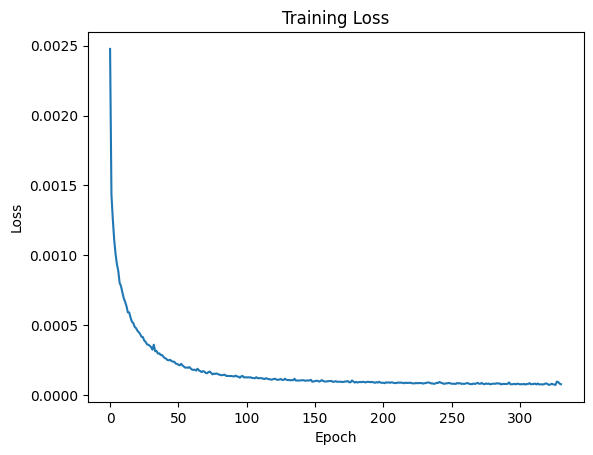

In [6]:
net = MTmodel()


net = MTmodel()
net = net.to(DEVICE)

optimizer = optim.Adam(net.parameters(), lr =  0.00020108)


EPOCHS = 331
losses = []
for epoch in range(EPOCHS):
  running_loss = 0.0
  correct = 0
  #current_accuracy = 0.0
  for batch_idx,(data, target) in enumerate(train_loader):

    data, target = data.to(DEVICE), target.view(-1).to(DEVICE)
    optimizer.zero_grad()
    output = net(data)
    loss = F.mse_loss(output.view(-1), target)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  epoch_loss = running_loss / batch_idx
  #current_accuracy = correct/ batch_idx
  losses.append(epoch_loss)

  # Print epoch loss
  print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss}")

# Plot the loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


mse: 0.000114788366475417, rmse: 0.01071393328686608, r2_score: 0.9496522791620537


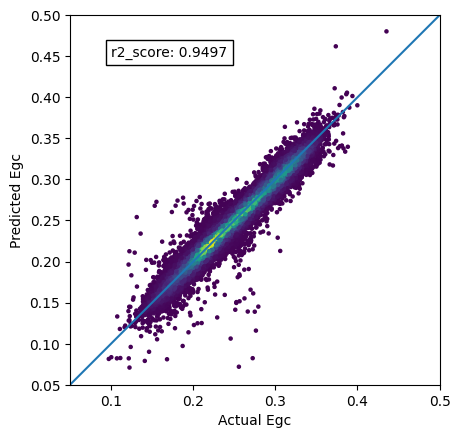

In [7]:
# Plot predictions vs. true values
from scipy.stats import gaussian_kde


@torch.no_grad()
def graphPredictions(model, data_loader , minValue, maxValue):
    
    model.eval()                               # Set the model to inference mode

    predictions=[]                             # Track predictions
    actual=[]                                  # Track the actual labels
    model = model.to(DEVICE)
    loss = []
    

    for batch_idx,(data, target) in enumerate(test_loader):

        # Single forward pass
        data, target =  data.to(DEVICE), target.to(DEVICE)
        pred = model(data)
                                     
        
        # Un-normalize our prediction
        pred = scalar.inverse_transform(pred.cpu().numpy())
        pred = torch.from_numpy(pred).to(DEVICE)
        target_cpu = scalar.inverse_transform(target.cpu().numpy())
        act = torch.from_numpy(target_cpu).to(DEVICE)
        

        # Save prediction and actual label
        predictions.append(tensor.cpu().item() for tensor in pred)
        actual.append(tensor.cpu().item() for tensor in act)

    pred_list = [item for sublist in predictions for item in sublist]
    act_list = [item for sublist in actual for item in sublist]
    
    #actual_array = np.squeeze(np.array(actual))
    mse = mean_squared_error(pred_list, act_list)
    rmse = mean_squared_error(pred_list, act_list, squared = False)
    r2 = r2_score(pred_list, act_list)
    print(f"mse: {mse}, rmse: {rmse}, r2_score: {r2}")

    
    
    # Plot actuals vs predictions
    
    xy = np.vstack([pred_list,act_list])
    z = gaussian_kde(xy)(xy)
    
    plt.scatter(pred_list, act_list, c=z, s=5)
    plt.xlabel('Actual Egc')
    plt.ylabel('Predicted Egc')
    plt.plot([minValue,maxValue], [minValue,maxValue])
    plt.xlim(minValue, maxValue)
    plt.ylim(minValue, maxValue)

    # Make the display equal in both dimensions
    plt.gca().set_aspect('equal', adjustable='box')
    text_x = 0.1
    text_y = 0.45
    plt.text(text_x, text_y, f"r2_score: {round(r2, 4)}", fontsize=10, bbox=dict(facecolor='white', alpha=1))
    plt.show()


graphPredictions(net, test_loader, 0.05, 0.5)